<a href="https://colab.research.google.com/github/devansurf/CoralSight-Binary/blob/main/CoralSight_Binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CoralSight Binary
Computer vision model to differentiate between bleached and non-bleached corals

In [76]:
 !pip install optuna

In [77]:
#Fetch dataset from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
#Libaries
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import optuna #tuner
import re
import random
import seaborn as sns
from collections import Counter
from itertools import chain

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, WeightedRandomSampler
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from torch.nn import Module, Conv2d, ConvTranspose2d, Dropout, BatchNorm2d
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import random_split


from PIL import Image

from collections import Counter
from tqdm import tqdm
from IPython.display import display, Math, Latex
from sklearn.utils import resample
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split

In [79]:
#directories
bleached_corals_dir = '/content/drive/MyDrive/MachineLearning/coral-dataset/bleached_corals'
healthy_corals_dir = '/content/drive/MyDrive/MachineLearning/coral-dataset/healthy_corals'

In [80]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [81]:
def to_numpy(x):

    return x.detach().cpu().numpy()

In [82]:
#Configuration
class Config:
    learning_rate = 0.00005
    num_epochs = 10
    batch_size = 32
    dropout = 0.2

    img_dimensions = (128, 128)
    target_count = 500

    training_proportion = 0.6
    validation_proportion = 0.3

    display_plots = True
    allow_tuner = False

In [83]:
class CoralDataset(Dataset):
    def __init__(self, images, labels, transform=None):

        assert len(images) == len(labels), "Length mismatch between bleached images and labels"
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = self.images[index]
        label = self.labels[index]

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [84]:
class CoralCNN(nn.Module):
    def __init__(self, dropout=0.5):
        super(CoralCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)


        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)  # Adjust the size (this is for 128x128)
        self.fc2 = nn.Linear(512, 1)
        self.dropout = nn.Dropout(dropout)

        def conv_output_size(size, kernel_size=3, stride=1, padding=1):
            return (size - kernel_size + 2 * padding) // stride + 1

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 16 * 16)  # Adjust the size (this is for 128x128)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

In [85]:
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [86]:
def train_model(learning_rate, num_epochs, dropout, train_loader, valid_loader):

    torch.manual_seed(69) # set seed

    model = CoralCNN(dropout=dropout)
    print(model) # print model architecture

    if torch.cuda.is_available():
        model = model.cuda()

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

    acc_hist_train = []
    acc_hist_val = []

    train_losses = []
    val_losses = []

    #when trending towards worse validation, stop
    early_stopper = EarlyStopper(patience=10, min_delta=0.1)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader):
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels.float())

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

            predicted = torch.round(outputs.data.squeeze())  # Round to 0 or 1

            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = correct_train / total_train
        acc_hist_train.append(train_accuracy)
        train_losses.append(train_loss)

        model.eval()
        valid_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in valid_loader:
                if torch.cuda.is_available():
                    images, labels = images.cuda(), labels.cuda()

                outputs = model(images)
                loss = criterion(outputs.squeeze(), labels.float())

                valid_loss += loss.item() * images.size(0)

                predicted = torch.round(outputs.data.squeeze())
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        if early_stopper.early_stop(valid_loss):
            print(f'Early Stop -> Epoch = {epoch+1}')
            break

        valid_loss = valid_loss / len(valid_loader.dataset)
        valid_accuracy = correct_val / total_val
        acc_hist_val.append(valid_accuracy)
        val_losses.append(valid_loss)

        print(f"Epoch: {epoch+1}")
        print(f"Train Acc: {train_accuracy:.3f}")
        print(f"Val Acc: {valid_accuracy:.3f}")
        print(f"Train Loss: {train_loss:.3f}")
        print(f"Val Loss: {valid_loss:.3f}")
        print("---------------------------------------------")

    #model = CoralCNN(dropout)
    model.eval()
    return model, acc_hist_train, acc_hist_val, train_losses, val_losses

In [87]:
#Function to oversample a subset
def oversample(image_paths, labels, target_count=Config.target_count):
    oversampled_image_paths = []
    oversampled_labels = []

    label_counts = Counter(labels)
    for label in label_counts:
        label_indices = [i for i, lbl in enumerate(labels) if lbl == label]
        oversampled_indices = random.choices(label_indices, k=target_count - label_counts[label])
        oversampled_image_paths.extend([image_paths[i] for i in oversampled_indices])
        oversampled_labels.extend([label] * len(oversampled_indices))

    return image_paths + oversampled_image_paths, labels + oversampled_labels

In [88]:
#Calculate mean std helper:
def calculate_mean_std(dataset, batch_size = 64):
    dataset_dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=True
    ) # this will allow us to iterate through images in batches

    mean = 0.
    std = 0.
    nb_samples = 0.
    for data, _ in tqdm(dataset_dataloader):
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples

    print(f'Mean: {mean}')
    print(f'Std: {std}')
    return mean, std

**Create the Datasets with the specified transform (augmentation)** 😀

In [89]:
bleached_images = [os.path.join(bleached_corals_dir, img) for img in os.listdir(bleached_corals_dir)]
healthy_images = [os.path.join(healthy_corals_dir, img) for img in os.listdir(healthy_corals_dir)]

all_images = bleached_images + healthy_images
all_labels = [0] * len(bleached_images) + [1] * len(healthy_images)

dataset = CoralDataset(all_images, all_labels, transforms.Compose([transforms.Resize(Config.img_dimensions), transforms.ToTensor()]))
#get mean and std of dataset
mean, std = calculate_mean_std(dataset)

#Define transforms (augmentations)
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.Resize(Config.img_dimensions),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transform = transforms.Compose([
    transforms.Resize(Config.img_dimensions),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])



#calculate lengths
total_size = len(dataset)
train_size = int(total_size * Config.training_proportion)
valid_size = int(total_size * Config.validation_proportion)
test_size = total_size - train_size - valid_size

def split_dataset(bleached_corals_dir, healthy_corals_dir, train_size, valid_size, test_size):

    # Combine bleached and healthy images and labels
    bleached_images = [os.path.join(bleached_corals_dir, img) for img in os.listdir(bleached_corals_dir)]
    healthy_images = [os.path.join(healthy_corals_dir, img) for img in os.listdir(healthy_corals_dir)]

    all_image_paths = bleached_images + healthy_images
    all_labels = [0] * len(bleached_images) + [1] * len(healthy_images)  # 0 for bleached, 1 for healthy

    # First split to separate out the training data
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        all_image_paths, all_labels, train_size=train_size, random_state=42)

    # Adjust validation_size to account for the reduced dataset size
    validation_size_adjusted = valid_size / (valid_size + test_size)

    # Split the remaining data into validation and test sets
    validation_paths, test_paths, validation_labels, test_labels = train_test_split(
        temp_paths, temp_labels, train_size=validation_size_adjusted, random_state=42)

    return train_paths, train_labels, validation_paths, validation_labels, test_paths, test_labels

#call the split dataset function
train_image_paths, train_labels, valid_image_paths, valid_labels, test_image_paths, test_labels = split_dataset(bleached_corals_dir, healthy_corals_dir, train_size, valid_size, test_size)

#Oversample the training subset
oversampled_train_image_paths, oversampled_train_labels = oversample(train_image_paths, train_labels)

#data was split this way in order to apply different transforms across subsets
train_dataset = CoralDataset(oversampled_train_image_paths, oversampled_train_labels, transform=train_transform)
valid_dataset = CoralDataset(valid_image_paths, valid_labels, transform=validation_transform)
test_dataset =  CoralDataset(test_image_paths, test_labels, transform=validation_transform)

#creating data loaders for each set
train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=Config.batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=Config.batch_size, shuffle=False)


100%|██████████| 15/15 [00:04<00:00,  3.45it/s]

Mean: tensor([0.3107, 0.4149, 0.4186])
Std: tensor([0.1885, 0.1902, 0.2042])


**Display some images and labels for reference**

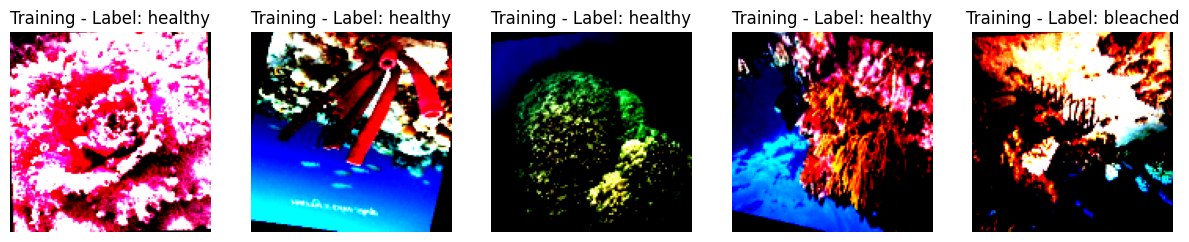

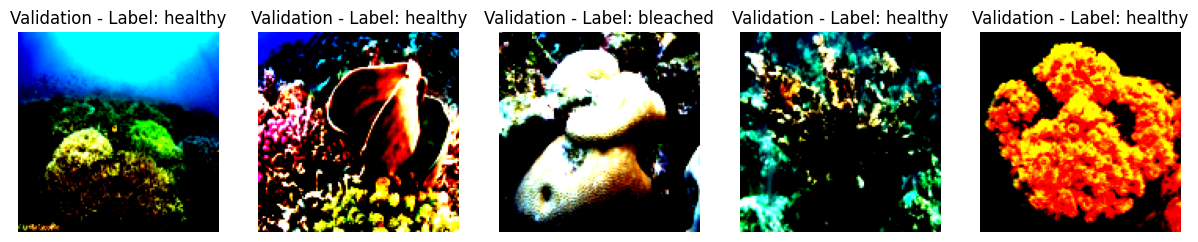

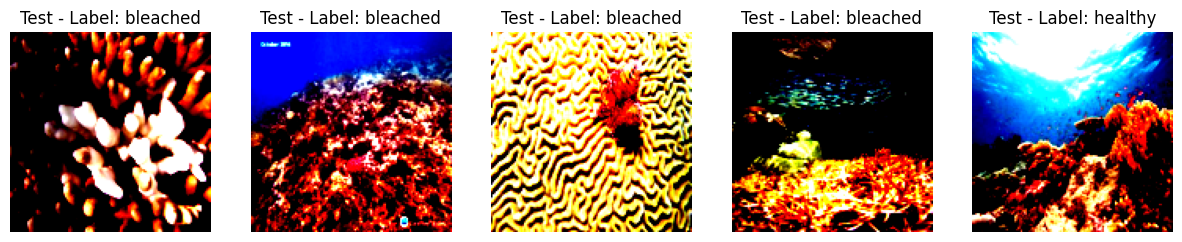

In [90]:
def show_random_images(subset, subset_name, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        # Randomly select an index
        idx = random.randint(0, len(subset) - 1)

        # Get the image and label
        image, label= subset[idx]
        label = 'bleached' if label == 0 else 'healthy'
        # Convert the tensor image to a NumPy array for visualization
        image_np = image.permute(1, 2, 0).numpy()

        # Subplot for each image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image_np)
        plt.title(f'{subset_name} - Label: {label}')
        plt.axis('off')

    plt.show()

if Config.display_plots:
    show_random_images(train_dataset, 'Training', num_images=5)
    show_random_images(valid_dataset, 'Validation', num_images=5)
    show_random_images(test_dataset, 'Test', num_images=5)

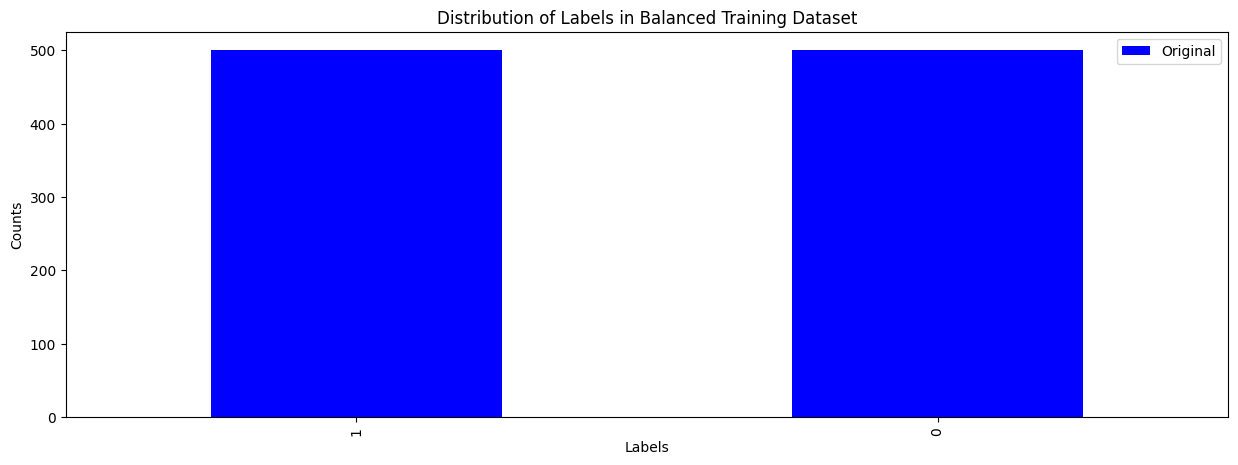

In [91]:
if Config.display_plots:
    counts = {}
    for _, label in train_dataset:
        if label in counts:
            counts[label] += 1
        else:
            counts[label] = 1

    counts_series = pd.Series(counts)

    # Plot the label counts
    plt.figure(figsize=(15, 5))
    # Plot original counts
    counts_series.plot(kind='bar', color='blue', label='Original')

    plt.xlabel('Labels')
    plt.ylabel('Counts')
    plt.title('Distribution of Labels in Balanced Training Dataset')
    plt.legend()
    plt.show()

**TUNER TIME**

In [92]:
#tuner function
def tuner(trial):
    # Define the hyperparameters to be tuned
    lr = trial.suggest_float('lr', 1e-6, 1e-4, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.4, 0.8)

    _, _, acc_hist_val = train_model(lr, Config.num_epochs, dropout_rate, train_loader, valid_loader)
    return max(acc_hist_val)

if Config.allow_tuner:
    study = optuna.create_study(direction='maximize')
    study.optimize(tuner, n_trials=100)

    best_params = study.best_params
    print("Best hyperparameters: ", best_params)

**Train the model !!!!**

In [93]:
model, acc_hist_train, acc_hist_val, train_losses, val_losses = train_model(Config.learning_rate, Config.num_epochs, Config.dropout, train_loader, valid_loader)

CoralCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


100%|██████████| 32/32 [01:06<00:00,  2.07s/it]


Epoch: 1
Train Acc: 0.691
Val Acc: 0.728
Train Loss: 0.622
Val Loss: 0.535
---------------------------------------------


100%|██████████| 32/32 [01:06<00:00,  2.08s/it]


Epoch: 2
Train Acc: 0.694
Val Acc: 0.710
Train Loss: 0.580
Val Loss: 0.604
---------------------------------------------


100%|██████████| 32/32 [01:05<00:00,  2.06s/it]


Epoch: 3
Train Acc: 0.759
Val Acc: 0.739
Train Loss: 0.495
Val Loss: 0.556
---------------------------------------------


100%|██████████| 32/32 [01:06<00:00,  2.07s/it]


Epoch: 4
Train Acc: 0.775
Val Acc: 0.761
Train Loss: 0.462
Val Loss: 0.500
---------------------------------------------


100%|██████████| 32/32 [01:06<00:00,  2.08s/it]


Epoch: 5
Train Acc: 0.775
Val Acc: 0.754
Train Loss: 0.453
Val Loss: 0.519
---------------------------------------------


100%|██████████| 32/32 [01:05<00:00,  2.04s/it]


Epoch: 6
Train Acc: 0.807
Val Acc: 0.783
Train Loss: 0.419
Val Loss: 0.532
---------------------------------------------


100%|██████████| 32/32 [01:04<00:00,  2.01s/it]


Epoch: 7
Train Acc: 0.809
Val Acc: 0.783
Train Loss: 0.412
Val Loss: 0.523
---------------------------------------------


100%|██████████| 32/32 [01:04<00:00,  2.02s/it]


Epoch: 8
Train Acc: 0.829
Val Acc: 0.757
Train Loss: 0.386
Val Loss: 0.550
---------------------------------------------


100%|██████████| 32/32 [01:08<00:00,  2.15s/it]


Epoch: 9
Train Acc: 0.819
Val Acc: 0.750
Train Loss: 0.405
Val Loss: 0.533
---------------------------------------------


100%|██████████| 32/32 [01:05<00:00,  2.05s/it]


Epoch: 10
Train Acc: 0.822
Val Acc: 0.786
Train Loss: 0.380
Val Loss: 0.531
---------------------------------------------


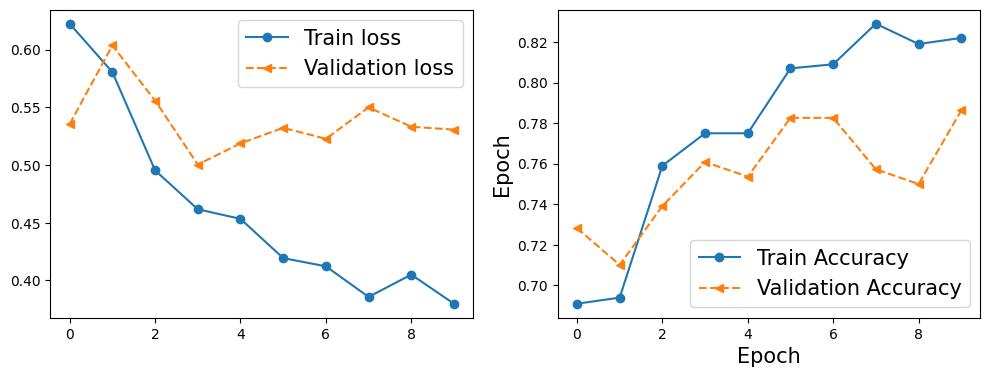

In [94]:
#Plot graphs

loss_axis = list(range(len(train_losses)))
val_axis = list(range(len(val_losses)))

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 1)

ax.plot(loss_axis, train_losses, '-o', label = 'Train loss')
ax.plot(val_axis , val_losses, '--<', label = 'Validation loss')
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(loss_axis, acc_hist_train, '-o', label='Train Accuracy')
ax.plot(val_axis, acc_hist_val, '--<', label='Validation Accuracy')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Epoch', size=15)
plt.show()

In [107]:
#Final results
total_correct = 0
total_samples = 0
actual_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        if torch.cuda.is_available():
            x, y = x.cuda(), y.cuda()

        pred = model(x)  # predict, this should output the probability of being class '1' (e.g., 'healthy')
        #add tuner to this
        predictions = (pred.squeeze() >= 0.65).int() # Threshold at 0.5; if pred >= 0.5, predictions = 1
        total_correct += (predictions == y).sum().item()
        total_samples += y.size(0)

        actual_labels.extend(to_numpy(y))
        predicted_labels.extend(to_numpy(predictions))

accuracy_test = total_correct / total_samples

print(f'test accuracy: {accuracy_test}')
print("NOTE: Test Accuracy above is provided for reference only. It can be a misleading statistic for imbalanced data.")
F1_score = f1_score(actual_labels, predicted_labels, average='macro')
print(f'F1_score: {F1_score}')

test accuracy: 0.8404255319148937
NOTE: Test Accuracy above is provided for reference only. It can be a misleading statistic for imbalanced data.
F1_score: 0.8350298350298351


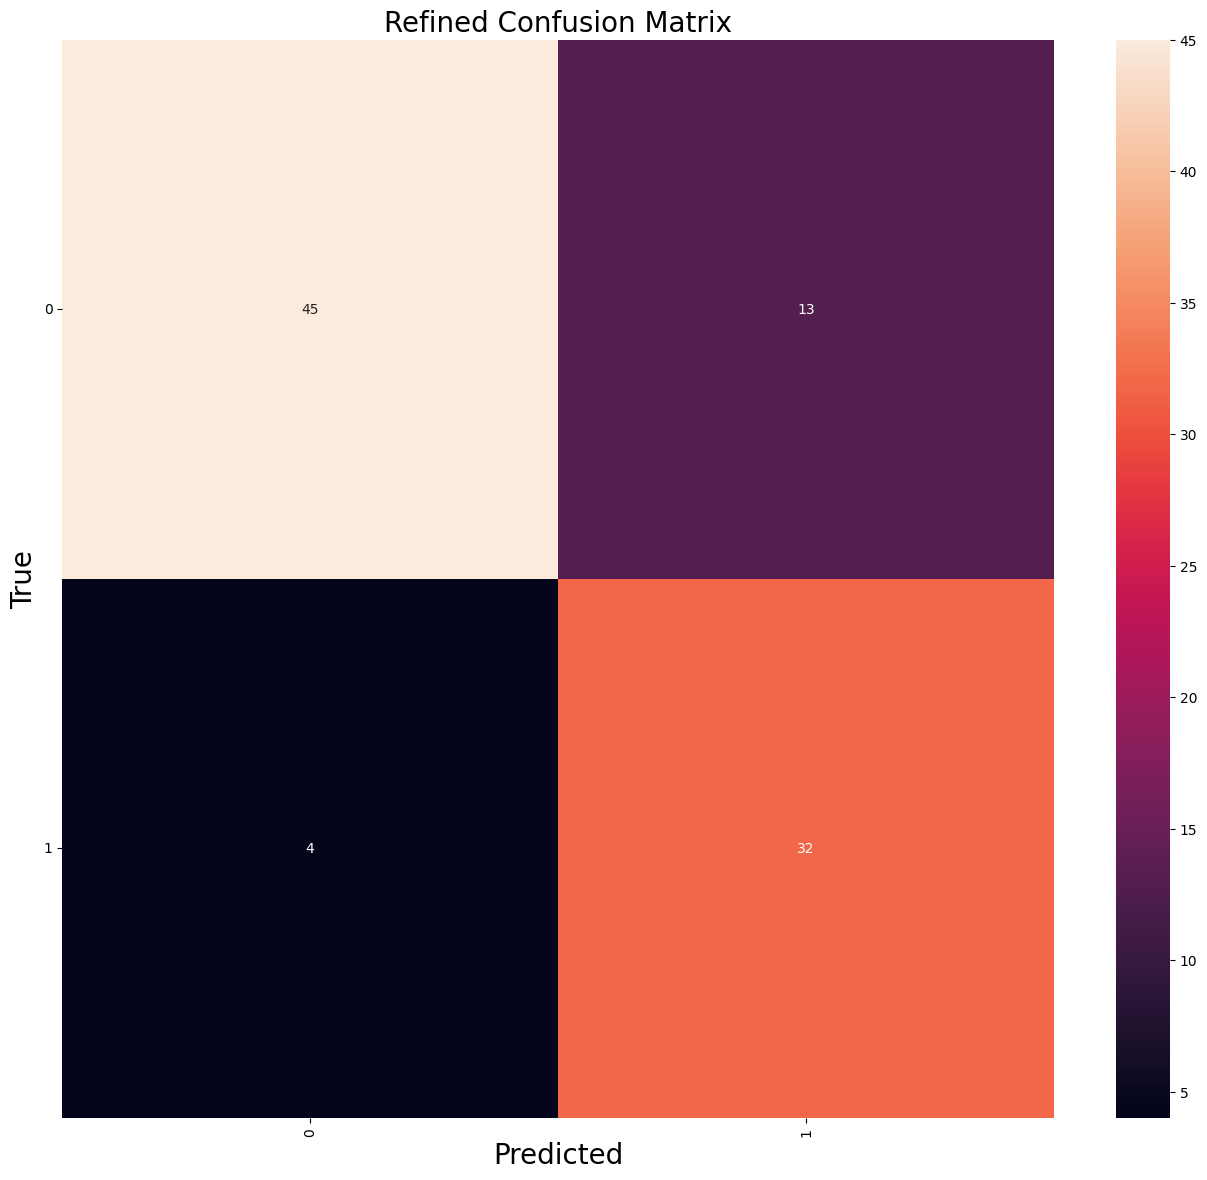

f1_score: 0.815622476058613


In [100]:
#Confusion matrix:
cm = confusion_matrix(actual_labels, predicted_labels)

labels = list(set(dataset.labels))

fig = plt.figure(figsize=(16, 14))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt="g")
ax.set_xlabel("Predicted", fontsize=20)
ax.xaxis.set_label_position("bottom")
plt.xticks(rotation=90)
ax.xaxis.tick_bottom()

ax.set_ylabel("True", fontsize=20)
plt.yticks(rotation=0)

plt.title("Refined Confusion Matrix", fontsize=20)

plt.show()

F1_score = f1_score(actual_labels, predicted_labels, average='macro')

print(f'f1_score: {F1_score}')